In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn

plt.rcParams["figure.figsize"] = (20, 9)

In [10]:
dataset_address = "../datasets/inertial-measurement-units/"
filename = "leg_extension_concentric_eccentric-000_00B46E19.csv"
df = pd.read_csv(dataset_address+filename, sep=",")

In [11]:
df["Acc_Mag"] = np.linalg.norm(df.loc[:, ["Acc_X", "Acc_Y", "Acc_Z"]], axis=1)
df["FreeAcc_Mag"] = np.linalg.norm(df.loc[:, ["FreeAcc_E", "FreeAcc_N", "FreeAcc_U"]], axis=1)
df["Gyr_Mag"] = np.linalg.norm(df.loc[:, ["Gyr_X", "Gyr_Y", "Gyr_Z"]], axis=1)
df["Mag_Mag"] = np.linalg.norm(df.loc[:, ["Mag_X", "Mag_Y", "Mag_Z"]], axis=1)
df.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,FreeAcc_E,FreeAcc_N,FreeAcc_U,Gyr_X,Gyr_Y,Gyr_Z,...,Mat[1][2],Mat[2][2],Mat[3][2],Mat[1][3],Mat[2][3],Mat[3][3],Acc_Mag,FreeAcc_Mag,Gyr_Mag,Mag_Mag
0,54437,9.448204,2.795508,-1.087186,0.008175,0.019923,0.100180,0.003596,0.000356,-0.014000,...,0.949130,0.142087,0.281005,-0.114741,0.987111,-0.111567,9.912890,0.102468,0.014459,0.781878
1,54438,9.447801,2.780835,-1.105421,-0.004995,-0.000485,0.097707,0.000983,0.003595,-0.016615,...,0.949080,0.142109,0.281162,-0.114761,0.987112,-0.111535,9.910396,0.097836,0.017028,0.788375
2,54439,9.437092,2.749807,-1.108972,-0.032798,-0.009378,0.079168,0.000727,0.001008,-0.020384,...,0.949018,0.142119,0.281365,-0.114751,0.987111,-0.111550,9.891914,0.086205,0.020422,0.787488
3,54440,9.424642,2.792023,-1.111783,0.009444,-0.007472,0.079491,-0.006627,0.001274,-0.016371,...,0.948978,0.142066,0.281529,-0.114692,0.987122,-0.111520,9.892185,0.080398,0.017707,0.790506
4,54441,9.391788,2.768613,-1.122069,-0.003644,-0.023771,0.042736,-0.004446,-0.000165,-0.018009,...,0.948930,0.142035,0.281705,-0.114650,0.987128,-0.111509,9.855452,0.049038,0.018550,0.782766


In [12]:
cols_X = ["Acc_X", "Acc_Y", "Acc_Z"] + ["FreeAcc_E", "FreeAcc_N", "FreeAcc_U"] + ["Gyr_X", "Gyr_Y", "Gyr_Z"] + ["Mag_X", "Mag_Y", "Mag_Z"]
cols_y = ["Acc_Mag", "FreeAcc_Mag", "Gyr_Mag", "Mag_Mag"]
data_X = df.loc[:, cols_X].values
data_y = df.loc[:, cols_y].values

In [13]:
# specify sizes of the partitions
# order is train, devset, test
partitions = [.7, .2, .1]

# split the data (note the third input, and the TMP in the variable name)
train_data, testdev_data, train_labels, testdev_label = train_test_split(data_X, data_y, train_size=partitions[0])

# now split the testdev_data
split = partitions[1] / np.sum(partitions[1:])
devset_data, test_data, devset_labels, test_labels = train_test_split(testdev_data, testdev_label, train_size=split)


In [14]:
def create_model(n_input=1, n_output=1, lr=.01):
    model = nn.Sequential(
        nn.Linear(n_input, n_input*5),
        nn.ReLU(),
        nn.Linear(n_input*5, n_input*10),
        nn.ReLU(),
        nn.Linear(n_input*10, n_input*5),
        nn.ReLU(), 
        nn.Linear(n_input*5, n_output)
    )

    # optimizer (the flavor of gradient descent to implement)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return model, optimizer

def train_model(X, y, model=None, loss_func=nn.MSELoss(), optimizer=None, n_epochs=1, plot_loss=False):
    # train the model
    losses = torch.zeros(n_epochs)
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    ## Train the model!
    for i in range(n_epochs):

        # forward pass
        yHat = model(X)

        # compute loss
        loss = loss_func(yHat, y)
        losses[i] = loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot(losses.detach())
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show();
    return losses

def evaluate_model(X, y, model):
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    # manually compute losses
    # final forward pass
    predictions = model(X)

    # final loss (MSE)
    test_loss = (predictions-y).pow(2).mean()
    # correlation between the predictions and the ground truth
    r = np.corrcoef(y.T, predictions.detach().T)
    r_mean = np.mean(r[np.triu_indices(r.shape[1], k=1)])

    COLORS = "bgrmykc"
    if y.ndim == 2:
        for feature_i in range(y.shape[1]):
            for sample_i in range(y.shape[0]):
                plt.scatter(sample_i, y[sample_i, feature_i], color=COLORS[feature_i], alpha=.5, linewidths=.5)
                plt.scatter(sample_i, predictions.detach()[sample_i, feature_i], color=COLORS[feature_i], alpha=.5, linewidths=1, marker="x")
        plt.xlabel("Samples")
        plt.ylabel("Values")
        plt.title(f"Avg. correleration between prediction and ground truth r={r_mean:.2f}\nFinal loss = {test_loss.item():.4f}")
        plt.show()
    else:
        print(f"The data has ndim: {y.ndim}, so it is not possible to plot the results.")
    
    return test_loss, r, r_mean, predictions

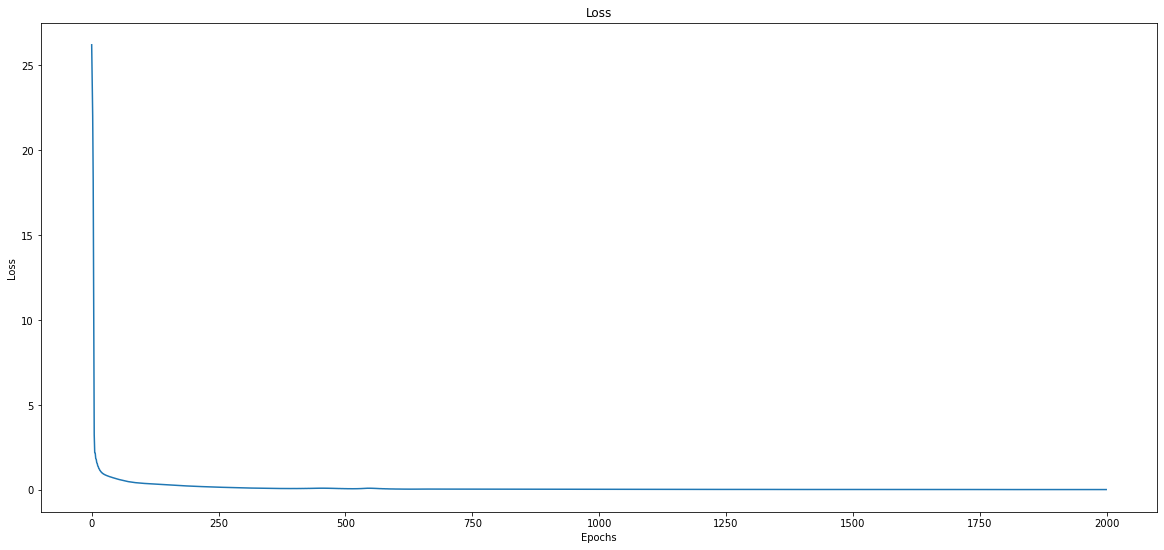

In [15]:
model, optimizer = create_model(n_input=len(cols_X), n_output=len(cols_y), lr=.01)
history = train_model(X=train_data, y=train_labels, model=model, loss_func=nn.MSELoss(), optimizer=optimizer, n_epochs=2000, plot_loss=True)

In [17]:
test_loss, r, r_mean, preds = evaluate_model(X=test_data, y=test_labels, model=model)
print(f"Test Loss: {test_loss:.4f}")
print(f"Avg. correleration between prediction and ground truth: {r_mean:.4f}")